In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 50.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


Using device: cuda
Model loaded successfully from 80_plantdoc_best_finetuned_byol_mim_contrastive_epoch85.pth1.pth
Class Names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


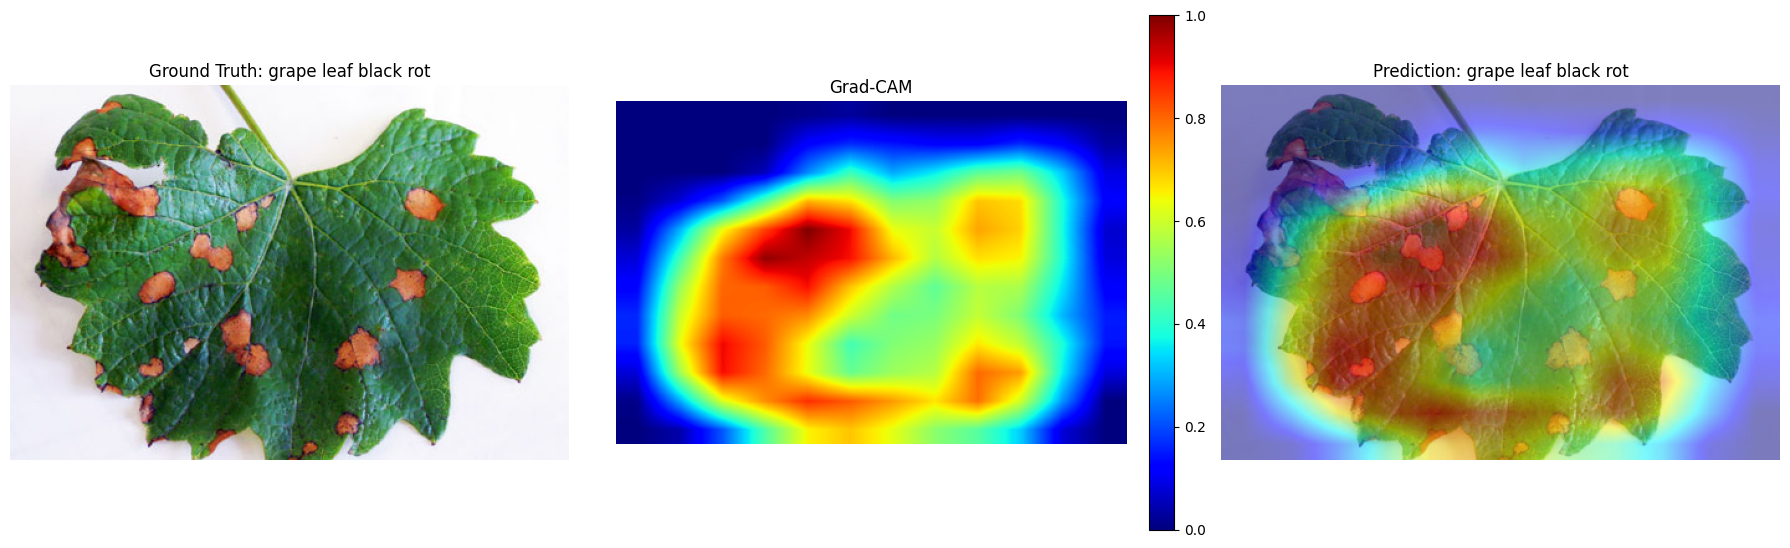

/tmp/ipykernel_318362/1026402770.py:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)  # or 'tab10' if <= 10 classes


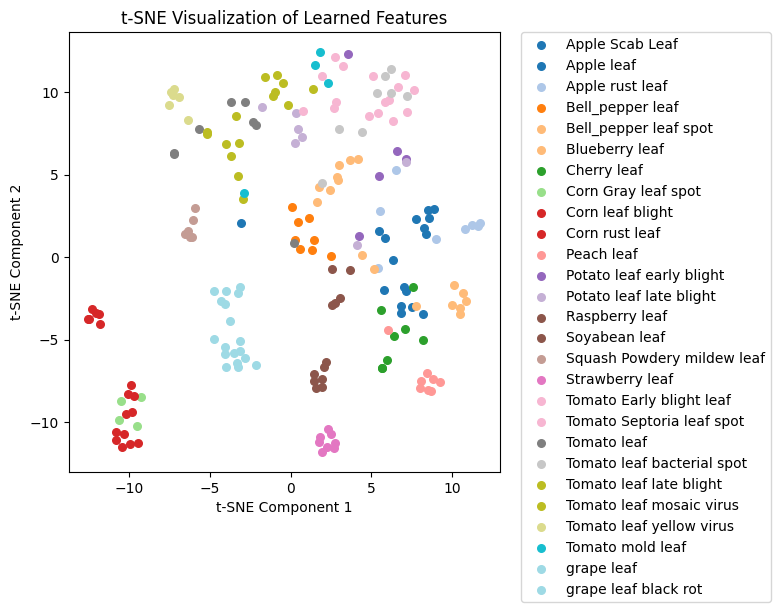

In [ ]:
#%% [markdown]
# # Complete Notebook: Three-Panel Grad-CAM & Labeled t-SNE
#
# This notebook demonstrates:
# 1. **Loading a fine-tuned model** from a checkpoint (e.g., 'plantdoc_best_finetuned_byol_mim_contrastive_epoch85.pth')
# 2. **Grad-CAM Visualization** in a 3-panel layout (original, raw heatmap, overlay).
# 3. **t-SNE Visualization** with a legend showing class names.

#%% [code]
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.manifold import TSNE
import random
import os

# Ensure Reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
# (Optional) For fully deterministic behavior (can slow down training/inference):
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#%% [markdown]
# ## 1. Model Definition and Loading Fine-Tuned Checkpoint

#%% [code]
class MLPClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

def build_model(num_classes=27):
    """
    Builds a ResNet101 with a custom classification head.
    Adjust `num_classes` to match your dataset.
    """
    model = models.resnet101(weights=None)
    model.fc = MLPClassifier(in_features=2048, num_classes=num_classes)
    return model

# Update these paths as needed
checkpoint_path = "plantdoc_best_finetuned_byol_mim_contrastive_epoch85.pth1.pth"  # Your .pth checkpoint
num_classes = 27  # Adjust if your dataset has a different number of classes

model = build_model(num_classes=num_classes).to(device)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

# Load the checkpoint
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Model loaded successfully from", checkpoint_path)

#%% [markdown]
# ## 2. Three-Panel Grad-CAM Visualization

#%% [code]
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model: The classification model.
            target_layer: The convolutional layer to target (e.g. model.layer4[-1] for ResNet101).
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        # Forward hook to store activations
        def forward_hook(module, input, output):
            self.activations = output.detach()
        # Full backward hook to store gradients (avoids partial hook warnings)
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class=None):
        """
        Returns a Grad-CAM heatmap (numpy array [H,W]) for the specified target_class.
        If target_class is None, uses the model's predicted class.
        """
        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        loss = output[0, target_class]
        loss.backward()

        # Grab stored gradients & activations
        gradients = self.gradients       # shape: [B, C, H, W]
        activations = self.activations   # shape: [B, C, H, W]

        # Compute channel-wise mean of gradients for weighting
        weights = torch.mean(gradients, dim=(2, 3))[0]  # shape: [C]

        # Create a tensor on the same device as activations
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]

        # Apply ReLU and normalize to [0,1]
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        # Move to CPU as numpy
        return cam.cpu().numpy()

def overlay_heatmap(original_img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlays a heatmap on the original image.

    Args:
        original_img (PIL.Image): The original input image.
        heatmap (np.array): Grad-CAM heatmap in [0,1].
        alpha (float): Transparency factor for overlay.
        colormap: OpenCV colormap for heatmap (e.g., cv2.COLORMAP_JET).
    """
    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (original_img.width, original_img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Convert PIL image to NumPy
    original_np = np.array(original_img)

    # Overlay
    overlay = cv2.addWeighted(original_np, 1 - alpha, heatmap, alpha, 0)
    return Image.fromarray(overlay)

def gradcam_visualization_3panel(
    image_path,
    ground_truth_label="Unknown",
    class_names=None
):
    """
    Produces a 3-panel Grad-CAM figure:
      1) Original image + Ground Truth label
      2) Raw Grad-CAM heatmap (with colorbar)
      3) Heatmap overlay + Predicted label
    """
    # Preprocessing (similar to your test-time transforms)
    preprocess = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Choose the last block of layer4 in ResNet101
    target_layer = model.layer4[-1]
    gradcam = GradCAM(model, target_layer)

    # Compute Grad-CAM
    cam = gradcam(input_tensor, target_class=None)

    # Remove hooks to avoid side effects
    gradcam.remove_hooks()

    # Get predicted class
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax(dim=1).item()
    if class_names is not None and 0 <= pred_idx < len(class_names):
        predicted_label = class_names[pred_idx]
    else:
        predicted_label = f"Class_{pred_idx}"

    # Prepare raw heatmap for the middle subplot
    raw_cam_resized = cv2.resize(cam, (img.width, img.height))

    # Create overlay image
    overlayed_img = overlay_heatmap(img, cam, alpha=0.5)

    # Plot side by side
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Left: Original image + Ground Truth
    ax[0].imshow(img)
    ax[0].set_title(f"Ground Truth: {ground_truth_label}", fontsize=12)
    ax[0].axis("off")

    # Middle: Raw Grad-CAM heatmap
    cax = ax[1].imshow(raw_cam_resized, cmap='jet', vmin=0, vmax=1)
    ax[1].set_title("Grad-CAM", fontsize=12)
    ax[1].axis("off")
    plt.colorbar(cax, ax=ax[1], fraction=0.046, pad=0.04)

    # Right: Overlay with predicted label
    ax[2].imshow(overlayed_img)
    ax[2].set_title(f"Prediction: {predicted_label}", fontsize=12)
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

#%% [markdown]
# ## 3. t-SNE Visualization of Learned Features (With Class Names)

#%% [code]
class FeatureExtractor(nn.Module):
    """
    Extracts features from the penultimate layer (avgpool) of ResNet101,
    i.e., everything except the final classification head.
    """
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)  # [B, 2048, 1, 1]
        x = torch.flatten(x, 1)  # [B, 2048]
        return x

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

def tsne_visualization(test_data_dir, sample_size=200, batch_size=16, class_names=None):
    """
    Extracts features from a subset of test images and visualizes them with t-SNE.
    Each color cluster is labeled by the class name.

    Args:
        test_data_dir (str): Directory of test images (ImageFolder format).
        sample_size (int): Number of images to sample for t-SNE.
        batch_size (int): Batch size for feature extraction.
        class_names (list[str]): List of class labels in correct order.
    """
    tsne_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(root=test_data_dir, transform=tsne_transform)

    # Randomly select a subset
    indices = np.random.choice(len(dataset), size=sample_size, replace=False)
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)

    features_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            features_list.append(feats.cpu())
            labels_list.extend(labels.numpy())

    features = torch.cat(features_list, dim=0).numpy()
    labels = np.array(labels_list)

    # Run t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # If you have many classes, consider a different colormap (e.g. 'tab20')
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    # Use a discrete colormap that can handle up to 27 classes (e.g., tab20 or tab10)
    colors = plt.cm.get_cmap('tab20', num_classes)  # or 'tab10' if <= 10 classes
    #colors = plt.colormaps.get_cmap('tab20', num_classes)


    for lbl in unique_labels:
        idx = (labels == lbl)
        label_name = class_names[lbl] if (class_names is not None and lbl < len(class_names)) else str(lbl)
        plt.scatter(
            features_2d[idx, 0],
            features_2d[idx, 1],
            c=[colors(lbl)],
            label=label_name,
            s=30
        )

    plt.title("t-SNE Visualization of Learned Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0)  # put legend on the right side
    plt.tight_layout()
    plt.show()

#%% [markdown]
# ## 4. Execute Visualizations

#%% [code]
# --- 4A. Run Three-Panel Grad-CAM Visualization ---
# Example usage with a single sample image
sample_image_path = "../PlantDoc-Dataset/test/grape leaf black rot/5-29black-rot-chardRR.jpg"
ground_truth_label = "grape leaf black rot"  # for display only

# We load class names from the training or test dataset (which must be labeled)
train_dataset = ImageFolder(root="../PlantDoc-Dataset/train")  # Adjust if needed
class_names = train_dataset.classes
print("Class Names:", class_names)

if not os.path.exists(sample_image_path):
    print(f"Sample image not found at {sample_image_path}.")
else:
    gradcam_visualization_3panel(
        image_path=sample_image_path,
        ground_truth_label=ground_truth_label,
        class_names=class_names
    )

#%% [code]
# --- 4B. Run t-SNE Visualization (with class names) ---
test_dataset_dir = "../PlantDoc-Dataset/test"
if not os.path.exists(test_dataset_dir):
    print(f"Test dataset directory not found at {test_dataset_dir}.")
else:
    tsne_visualization(
        test_data_dir=test_dataset_dir,
        sample_size=200,
        batch_size=16,
        class_names=class_names  # pass in the same class_names
    )
